In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from typing import List, Tuple
from math import floor
import random
from itertools import chain
from thesispy.definitions import ROOT_DIR, IMG_DIR

cmap = plt.get_cmap("Paired").colors

# plt.style.use(["science", "high-vis", ROOT_DIR / "resources/plt_custom.txt"])
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

class Point:
  def __init__(self, x: float = 0.0, y: float = 0.0):
    self.x = x
    self.y = y

  def __mul__(self, other):
    return Point(
        self.x * float(other),
        self.y * float(other)
    )

  def __add__(self, other):
    return Point(
        self.x + other.x,
        self.y + other.y
    )
  
  def __str__(self):
    return f"({self.x}, {self.y})"

  def reset(self):
    self.x = 0.0
    self.y = 0.0
  
  __rmul__ = __mul__
  __repr__ = __str__

def cubic_bspline_0(t: float):
  return (-t**3 + 3*t**2 - 3*t + 1)/6

def cubic_bspline_1(t: float):
  return (3*t**3 - 6*t**2 + 4)/6

def cubic_bspline_2(t: float):
  return (-3*t**3 + 3*t**2 + 3*t + 1)/6

def cubic_bspline_3(t: float):
  return t**3/6

cubic_bsplines = [cubic_bspline_0, cubic_bspline_1, cubic_bspline_2, cubic_bspline_3]

def cubic_bspline_patch(x: float, y: float, c: List[List[Point]], verbose=False):
  res = Point()
  i = floor(x)
  j = floor(y)

  if (i == 0 or i + 3 > len(c)) or (j == 0 or j + 3 > len(c)):
    if verbose:
      print(f"Patch is not defined for ({x},{y}).")
    return None

  for m in range(4):
    for n in range(4):
      if verbose:
        print(f"bspline_{m}({x-i}) * bspline_{n}({y-j}) * {c[i+m-1][j+n-1]}")
      res += cubic_bsplines[m](x - i) * cubic_bsplines[n](y-j) * c[i+m-1][j+n-1]
  
  return res

def cubic_affected_pixels(s: List[Tuple], c: List[List[Point]]):
  flatten_c = list(chain.from_iterable(c))
  flatten_s = [c[m][n] for m,n in s]
  max_limit = Point(max([p.x for p in flatten_c]) - 1, max([p.y for p in flatten_c]) - 1)
  min_limit = Point(min([p.x for p in flatten_c]) + 1, min([p.y for p in flatten_c]) + 1)
  
  res = []
  for m,n in s:
    p1 = Point(max(min_limit.x, c[m][n].x-2), max(min_limit.y, c[m][n].y-2))
    p2 = Point(min(max_limit.x, c[m][n].x+2), min(max_limit.y, c[m][n].y+2))
    res.append((p1,p2))

  return res


def generate_grid(n: int, r=False):
  res = []
  for i in range(n):
    res.append([Point(i+random.uniform(0, 1), j+random.uniform(0, 1)) if r else Point(i, j) for j in range(n)])
  return np.array(res)

def plot_patch(c, ax=None):
  if ax is None:
    _, ax = plt.subplots(figsize=(6,6))
  cpoints_x = [p.x for p in c.flatten()]
  cpoints_y = [p.y for p in c.flatten()]
  ax.scatter(cpoints_x, cpoints_y, c='black', marker='+', zorder=100)

  axis_vals = np.linspace(0, c.shape[0], 100)

  for x in range(2, c.shape[0]-1):
    p1 = []
    p2 = []
    for y in axis_vals:
      p1.append(cubic_bspline_patch(x, y, c))
      p2.append(cubic_bspline_patch(y, x, c))

    p1 = np.array(p1)
    p2 = np.array(p2)
    p1_x = [p.x for p in p1.flatten()[p1 != np.array(None)]]
    p1_y = [p.y for p in p1.flatten()[p1 != np.array(None)]]
    p2_x = [p.x for p in p2.flatten()[p2 != np.array(None)]]
    p2_y = [p.y for p in p2.flatten()[p2 != np.array(None)]]

    ax.plot(p1_x, p1_y, c=cmap[5], linestyle='-')
    ax.plot(p2_x, p2_y, c=cmap[5], linestyle='-')

def generate_dvf(c):
  dvf = np.zeros(list(c.shape) + [2])
  for p in np.ndindex(c.shape):
    mappedPoint = cubic_bspline_patch(p[0], p[1], c)
    if mappedPoint:
      direction = c[p] + -1 * mappedPoint
      dvf[p][0] = direction.x
      dvf[p][1] = direction.y
  return dvf   


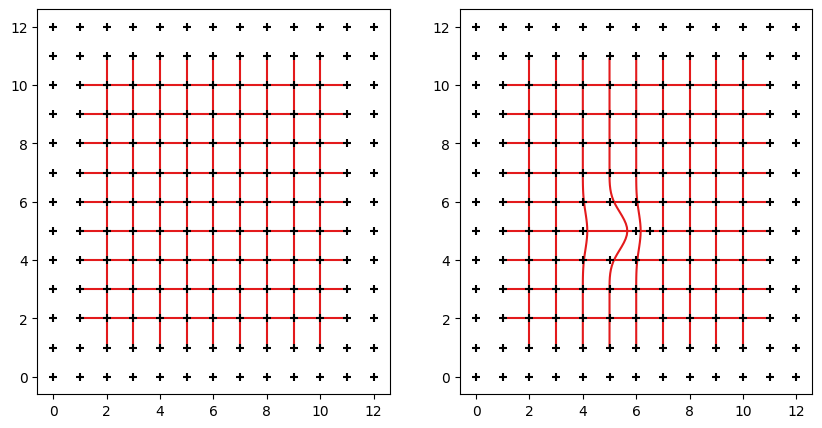

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

grid_size = 13
c = generate_grid(grid_size, False)

plot_patch(c, ax=axes[0])

c[5][5] = Point(6.5, 5)


plot_patch(c, ax=axes[1])

# plt.savefig(IMG_DIR / "bspline_patches.pgf", dpi=300, bbox_inches='tight')

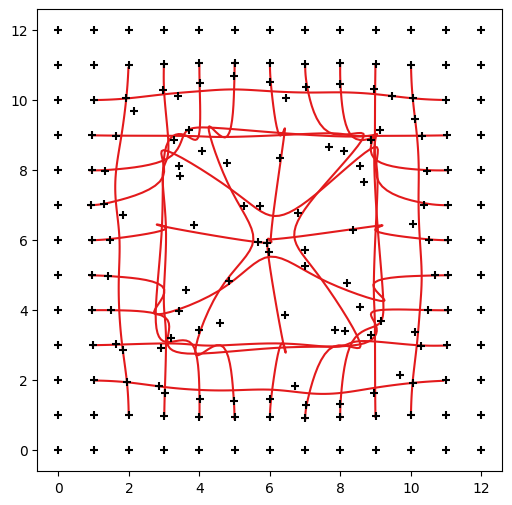

In [8]:
asgd_points = np.loadtxt("points.txt")
grid = np.empty(shape=(13, 13), dtype=object)
for p in asgd_points:
    if p[2] == 6:
        grid[int(p[0])][int(p[1])] = Point((p[3]+3)/3, (p[4]+3)/3)
        # if p[1] < 6:
        #     grid[int(p[0])][int(p[1])] = Point(p[3], p[4])
        # else:
        #     grid[int(p[0])][int(p[1])] = Point(p[0]*3 - 3, p[1]*3-3)

plot_patch(grid)

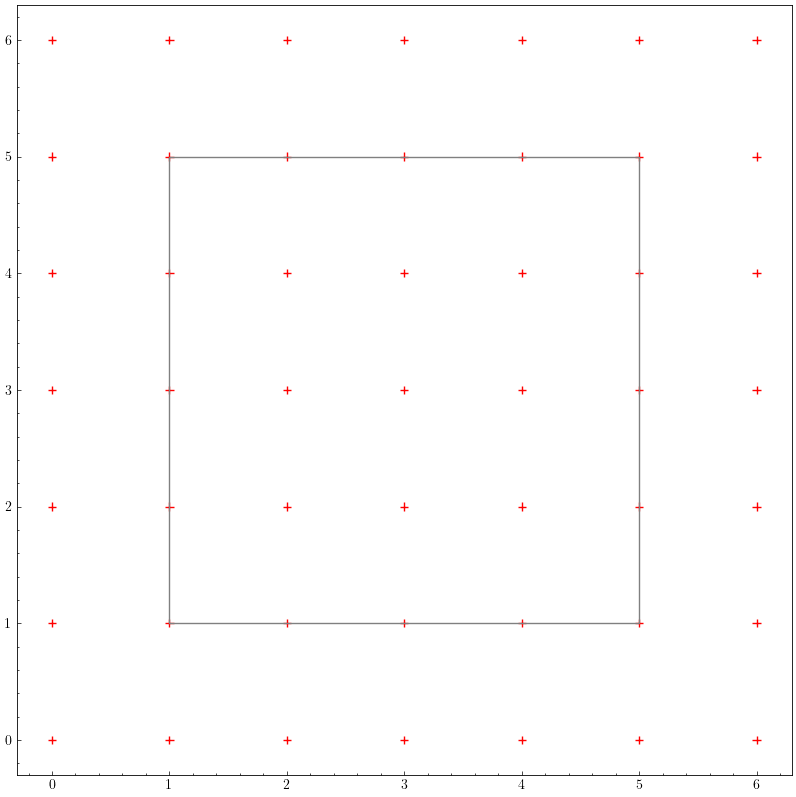

In [3]:
n = 7
dist = n-3
c = generate_grid(n)
colors = [['r' for _ in x] for x in c]
selection = []
for m,n in selection:
  colors[m][n] = 'b'
rects = cubic_affected_pixels(selection, c)
colors = list(chain.from_iterable(colors))

fig, ax = plt.subplots(figsize=(10,10))
cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]
ax.scatter(cpoints_x, cpoints_y, c=colors, marker='+')

outer_rect = patches.Rectangle((1, 1), dist, dist, linewidth=1, edgecolor='gray', facecolor='none')
ax.add_patch(outer_rect)

for p1, p2 in rects:
  rect = patches.Rectangle((p1.x, p1.y), p2.x - p1.x, p2.y - p1.y, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(rect)

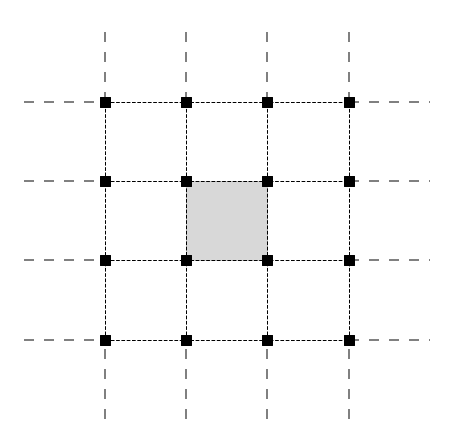

In [23]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

for i in range(grid_size):
    plt.plot([i, i], [0, grid_size - 1], c='black', linestyle='--')
    plt.plot([i, i], [-1, 0], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([i, i], [grid_size - 1, grid_size], c='gray', linestyle=(0, (5, 5)), linewidth=2)

    plt.plot([0, grid_size - 1], [i, i], c='black', linestyle='--')
    plt.plot([-1, 0], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([grid_size - 1, grid_size], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)    

plt.fill_between([1, 2], [2, 2], [1, 1], color='gray', alpha=0.3)
plt.scatter(cpoints_x, cpoints_y, c='black', marker='s', s=100, zorder=100)

plt.savefig(IMG_DIR / "bspline_patch_cpoints.pdf")

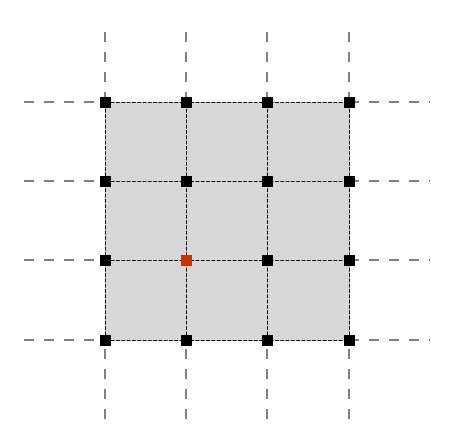

In [28]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')

grid_size = 4
c = generate_grid(grid_size, False)

cpoints_x = [p.x for p in c.flatten()]
cpoints_y = [p.y for p in c.flatten()]

for i in range(grid_size):
    plt.plot([i, i], [0, grid_size - 1], c='black', linestyle='--')
    plt.plot([i, i], [-1, 0], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([i, i], [grid_size - 1, grid_size], c='gray', linestyle=(0, (5, 5)), linewidth=2)

    plt.plot([0, grid_size - 1], [i, i], c='black', linestyle='--')
    plt.plot([-1, 0], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)
    plt.plot([grid_size - 1, grid_size], [i, i], c='gray', linestyle=(0, (5, 5)), linewidth=2)

plt.scatter([1], [1], c='#cc3300', marker='s', s=100, zorder=200)
plt.scatter(cpoints_x, cpoints_y, c='black', marker='s', s=100, zorder=100)
plt.fill_between([0, 3], [0, 0], [3, 3], color='gray', alpha=0.3)

plt.savefig(IMG_DIR / "bspline_cpoint_patches.pdf")